In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler

from yellowbrick.regressor import PredictionError, ResidualsPlot
from yellowbrick.model_selection import FeatureImportances

import pickle

In [3]:
df = pd.read_csv('datasets/insurance.csv')

<h1 style='background-color: #2C8695; color:#FFFFFF; text-align:center'>Análisis exploratorio</h1>

In [4]:
df.head()

,age,sex,bmi,children,smoker,region,expenses
0,19,female,27.9,0,yes,southwest,16884.92
1,18,male,33.8,1,no,southeast,1725.55
2,28,male,33.0,3,no,southeast,4449.46
3,33,male,22.7,0,no,northwest,21984.47
4,32,male,28.9,0,no,northwest,3866.86


In [5]:
print('El dataset tiene {} columnas y {} filas'.format(df .shape[1], df.shape[0]))

El dataset tiene 7 columnas y 1338 filas


¿Cuál es la naturaleza de los datos?

In [6]:
print('Información del dataframe:\n')
df.info()

Información del dataframe:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   expenses  1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


No tenemor valores nulos.

Tipo de los datos:
* **int64**: age, children.
* **float64**: bmi, expenses.
* **object**: sex, smoker, region 

<h1 style='background-color: #2C8695; color:#FFFFFF; text-align:center'>Análisis de datos</h1>
Analizaremos los efectos que tienen los atributos sobre la variable objetivo`expenses`

In [7]:
def atributos_vs_objetivo(atributo, objetivo, dataframe):
    """Crea una tabla resumen del promedio del atributo en contra del objetivo y devuelve un dataframe.

    Args:
        atributo ([List]): [Atributo a analizar]
        objetivo ([List]): [Variable objetivo]
        dataframe ([DataFrame]): [Dataframe a analizar]

    Returns:
        tabla ([DataFrame]): [Tabla con el promedio de cada atributo en contra del objetivo]
    """
    tabla = dataframe[[atributo, objetivo]].groupby(atributo, as_index=False).mean().sort_values(by=objetivo, ascending=False).style.background_gradient(cmap='Blues')
    return tabla  

In [8]:
sex_expenses = atributos_vs_objetivo('sex', 'expenses', df)
sex_expenses

,sex,expenses
1,male,13956.751420
0,female,12569.578897


En promedio los hombres deben desembolsar más dinero a la hora de contratar un seguro de salud.

In [9]:
children_expenses = atributos_vs_objetivo('children', 'expenses', df)
children_expenses

,children,expenses
3,3,15355.318535
2,2,15073.564000
4,4,13850.656800
1,1,12731.171821
0,0,12365.975767
5,5,8786.035556


En promedio, las familiar deben pagar más dinero al tener entre 2 y 4 hijos.

In [10]:
smoker_expenses = atributos_vs_objetivo('smoker', 'expenses', df)
smoker_expenses

,smoker,expenses
1,yes,32050.231971
0,no,8434.268449


Las personas fumadoras pagan en promedio casi 4 veces lo que paga una persona no fumadora, lo cual puede tener mucha influencia a la hora de modelarlo.

In [11]:
region_expenses = atributos_vs_objetivo('region', 'expenses', df)
region_expenses

,region,expenses
2,southeast,14735.411538
0,northeast,13406.384691
1,northwest,12417.575169
3,southwest,12346.937908


La región más cara es 'southeast' y por el contrario la más barata es 'southwest' 

In [12]:
df[['region', 'sex', 'bmi', 'expenses']].groupby(['region'], as_index=False).mean().sort_values(by=['expenses'], ascending=False).style.background_gradient(cmap='Blues')

,region,bmi,expenses
2,southeast,33.359341,14735.411538
0,northeast,29.176235,13406.384691
1,northwest,29.201846,12417.575169
3,southwest,30.596615,12346.937908


In [13]:
# Anlisis bmi ranges
bmi_ranges = np.where(df['bmi'] < 18.5, 'bajo peso', 
             np.where(df['bmi'] < 25, 'peso normal', 
             np.where(df['bmi'] < 30, 'sobrepeso', 
             'obesidad')))

Rangos de bmi, según [NHS](https://www.nhs.uk/common-health-questions/lifestyle/what-is-the-body-mass-index-bmi/)

In [14]:
df['bmi_range'] = bmi_ranges

In [15]:
bmi_range_table = atributos_vs_objetivo('bmi_range', 'expenses', df)
bmi_range_table

,bmi_range,expenses
1,obesidad,15552.335728
3,sobrepeso,11000.079306
2,peso normal,10379.499775
0,bajo peso,8852.201500


Los costos de los seguros de salud son más caros, mientras mayor índice de masa corporal tenga la persona.

In [16]:
df.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'expenses',
       'bmi_range'],
      dtype='object')

<h1 style='background-color: #2C8695; color:#FFFFFF; text-align:center'>Visualización de datos</h1>

Visualizaremos las variables del dataset y sacaremos información de:
* Sex
* Age
* Children
* Smoker
* Region
* Expenses

<h2 style='background-color: #2C8695; color:#FFFFFF; text-align:left'>Sex</h2>

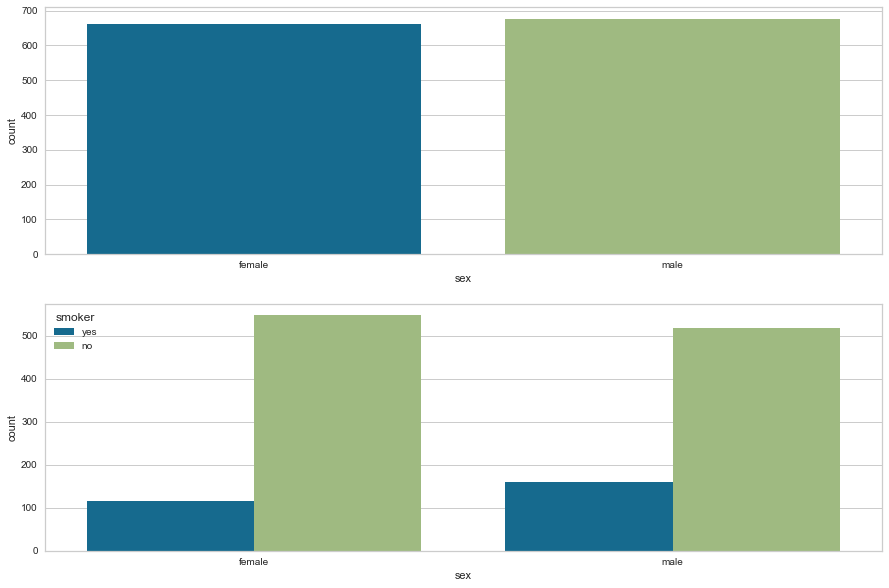

In [17]:
fig, ax = plt.subplots(2, figsize=(15,10))

sns.countplot(ax=ax[0] , x='sex', data=df)
sns.countplot(ax=ax[1] , x='sex', data =df, hue='smoker');

* Hay una cantidad muy similas de hombres y mujeres en el dataset.
* La proporción de fumadores es similas en ambos sexos, sin embargo los hombres tienen un mayor porcentaje de fumadores que las mujeres.

<h2 style='background-color: #2C8695; color:#FFFFFF; text-align:left'>Age</h2>

In [18]:
avg_age_region = df[['region', 'age']].groupby('region', as_index=False).mean()
avg_age_sex = df[['sex', 'age']].groupby('sex', as_index=False).mean()
avg_age_children = df[['children', 'age']].groupby('children', as_index=False).mean()

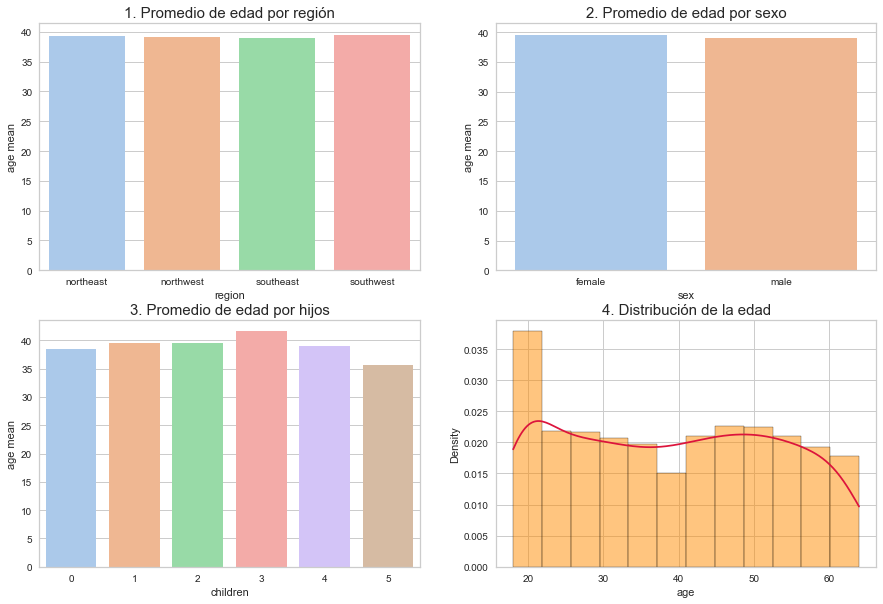

In [19]:
fig, ax = plt.subplots(2,2, figsize =(15,10))

sns.barplot(ax=ax[0,0], x='region', y='age', data=avg_age_region, palette='pastel')
ax[0,0].set_title('1. Promedio de edad por región', fontdict={'fontsize': '15'})
ax[0,0].set_ylabel('age mean')	

sns.barplot(ax=ax[0,1], x='sex', y='age', data=avg_age_sex, palette='pastel')
ax[0,1].set_title('2. Promedio de edad por sexo', fontdict={'fontsize': '15'})
ax[0,1].set_ylabel('age mean')

sns.barplot(ax=ax[1,0], x='children', y='age', data=avg_age_children, palette='pastel')
ax[1,0].set_title('3. Promedio de edad por hijos', fontdict={'fontsize': '15'})	
ax[1,0].set_ylabel('age mean')

sns.histplot(ax=ax[1,1] , x='age', data=df, stat='density', color='darkorange', kde=True)
ax[1,1].set_title('4. Distribución de la edad', fontdict={'fontsize': '15'})	
ax[1,1].lines[0].set_color('crimson')

plt.show()

1. La variación de edad de la gente entre regiones es muy poca.
2. El promedio de edad es casi el mismo en ambos géneros, siendo mayor en las mujeres.
3. El promedio de edad de las personas que tienen 3 hijos es el mayor, por otra parte las que tienen 5 hilos tienen la menor edad en promedio.
4. La edad de las personas no sigue una distribución normal, tiene el sesgo a la izquierda, puede ser corregida.

<h2 style='background-color: #2C8695; color:#FFFFFF; text-align:left'>Children</h2>

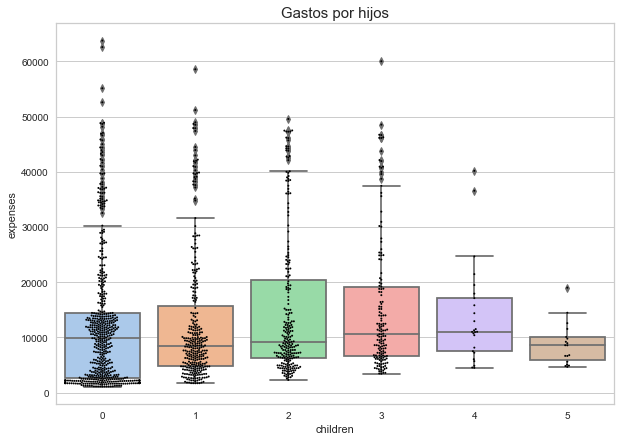

In [20]:
fig, ax = plt.subplots(figsize=(10,7))
sns.boxplot(x='children', y='expenses', data=df, palette='pastel')
sns.swarmplot(x='children', y='expenses', data=df, color='black', size=2)
ax.set_title('Gastos por hijos', fontdict={'fontsize': '15'});

* Las personas que tienen mayores costos son las que tienen 2 hijos, y las que menos las que tienen 5 hijos, sin embargo puede que esto no sea tan real, ya que las personas que tienen 4 o 5 hijos son muy pocas, entonces puede que no sea representativo.

<h2 style='background-color: #2C8695; color:#FFFFFF; text-align:left'>Smoker</h2>

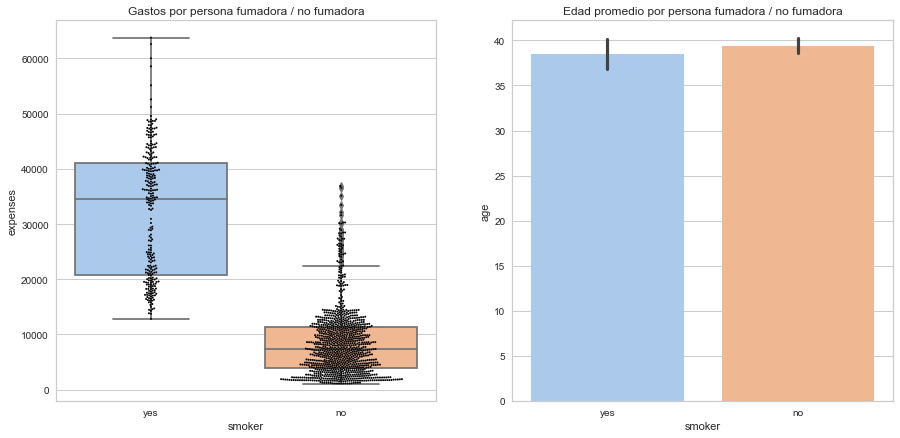

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(15,7))
sns.boxplot(ax=ax[0], x='smoker', y='expenses', data=df, palette='pastel')
sns.swarmplot(ax=ax[0], x='smoker', y='expenses', data=df, color='black', size=2)
sns.barplot(ax=ax[1], x='smoker', y='age', data=df, palette='pastel')
ax[0].set_title('Gastos por persona fumadora / no fumadora', fontdict={'fontsize': '12'})
ax[1].set_title('Edad promedio por persona fumadora / no fumadora', fontdict={'fontsize': '12'});

* Las personas que son fumadoras pagan mucho más que las personas que no lo son.
* La edad promedio de las personas fumadoras comparado con las no fumadoras, son muy similares, en torno a los 38 años.

<h2 style='background-color: #2C8695; color:#FFFFFF; text-align:left'>Region</h2>

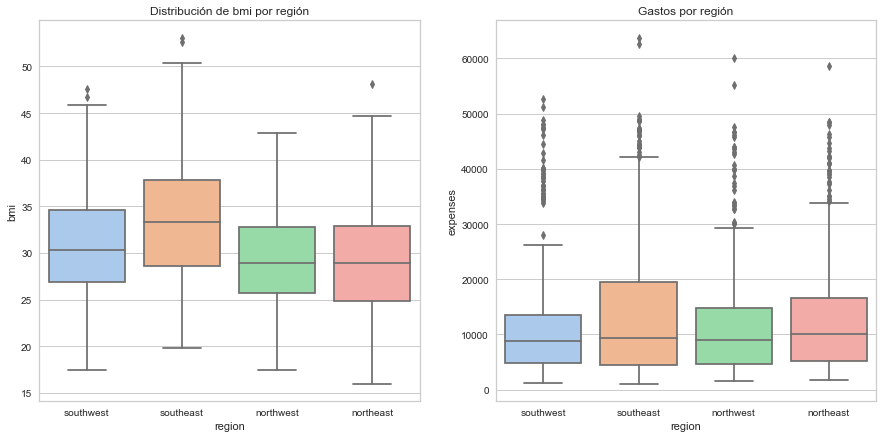

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(15,7))
sns.boxplot(ax=ax[0], x='region', y='bmi', data=df, palette='pastel')
sns.boxplot(ax=ax[1], x='region', y='expenses', data=df, palette='pastel')

ax[0].set_title('Distribución de bmi por región', fontdict={'fontsize': '12'})
ax[1].set_title('Gastos por región', fontdict={'fontsize': '12'});

* La región **`Southeast`** es la que tiene gente con mayor BMI.
* La región que más gasta en seguros, coincide con la de mayor BMI.

<h2 style='background-color: #2C8695; color:#FFFFFF; text-align:left'>Expenses</h2>

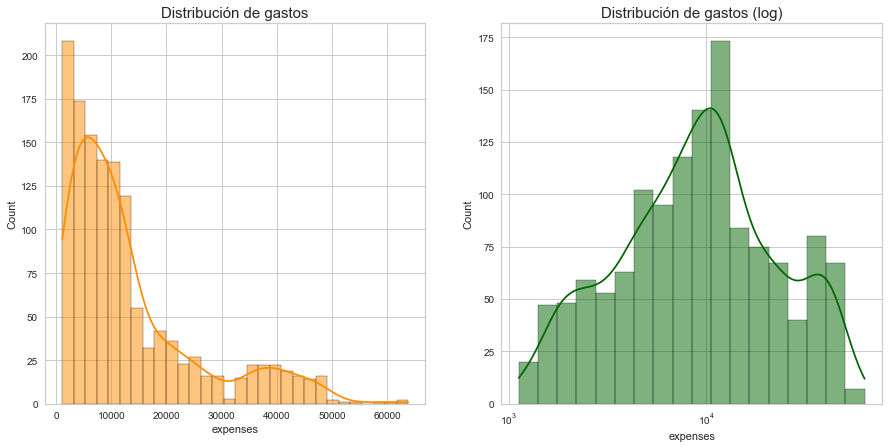

In [23]:
fig, ax = plt.subplots(1,2, figsize=(15,7))
sns.histplot(ax=ax[0], x='expenses', data=df, color='darkorange', kde=True)
sns.histplot(ax=ax[1], x='expenses', data=df, color='darkgreen', kde=True, log_scale=True)

ax[0].set_title('Distribución de gastos', fontdict={'fontsize': '15'})
ax[1].set_title('Distribución de gastos (log)', fontdict={'fontsize': '15'});

* La distribución de gastos sigue una **curva normal asimétrica con sesgo negativo**
* El segundo gráfico muestra la distribución de gastos con una transformación logarítmica, y sse aprecia que se ajusta mejor a una distribución normal, podremos probar esta transformación en el modelo, para ver si arroja un mejor resultado.

<h1 style='background-color: #2C8695; color:#FFFFFF; text-align:center'>Featuring Engineering</h1>

In [24]:
df.head()

,age,sex,bmi,children,smoker,region,expenses,bmi_range
0,19,female,27.9,0,yes,southwest,16884.92,sobrepeso
1,18,male,33.8,1,no,southeast,1725.55,obesidad
2,28,male,33.0,3,no,southeast,4449.46,obesidad
3,33,male,22.7,0,no,northwest,21984.47,peso normal
4,32,male,28.9,0,no,northwest,3866.86,sobrepeso


<h2 style='background-color: #2C8695; color:#FFFFFF; text-align:left'>Cambiar tipo de datos</h2>

Cambiamos a category el tipo de datos que corresponden a alguna categoría.

In [25]:
df['sex'] = df['sex'].astype('category')
df['region'] = df['region'].astype('category')
df['smoker'] = df['smoker'].astype('category')
df.drop(columns=['bmi_range'], inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   age       1338 non-null   int64   
 1   sex       1338 non-null   category
 2   bmi       1338 non-null   float64 
 3   children  1338 non-null   int64   
 4   smoker    1338 non-null   category
 5   region    1338 non-null   category
 6   expenses  1338 non-null   float64 
dtypes: category(3), float64(2), int64(2)
memory usage: 46.3 KB


<h2 style='background-color: #2C8695; color:#FFFFFF; text-align:left'>One-Hot Encoding</h2>

Para pasar las variables categóricas a variables numéricas que puedan ser usadas por los modelos de Machine Learning.

In [26]:
df = pd.get_dummies(df, columns = ['sex', 'region', 'smoker', ], drop_first=True)

In [27]:
df.head(3)

,age,bmi,children,expenses,sex_male,region_northwest,region_southeast,region_southwest,smoker_yes
0,19,27.9,0,16884.92,0,0,0,1,1
1,18,33.8,1,1725.55,1,0,1,0,0
2,28,33.0,3,4449.46,1,0,1,0,0



<h2 style='background-color: #2C8695; color:#FFFFFF; text-align:left'>Variable objetivo: Expenses</h2>

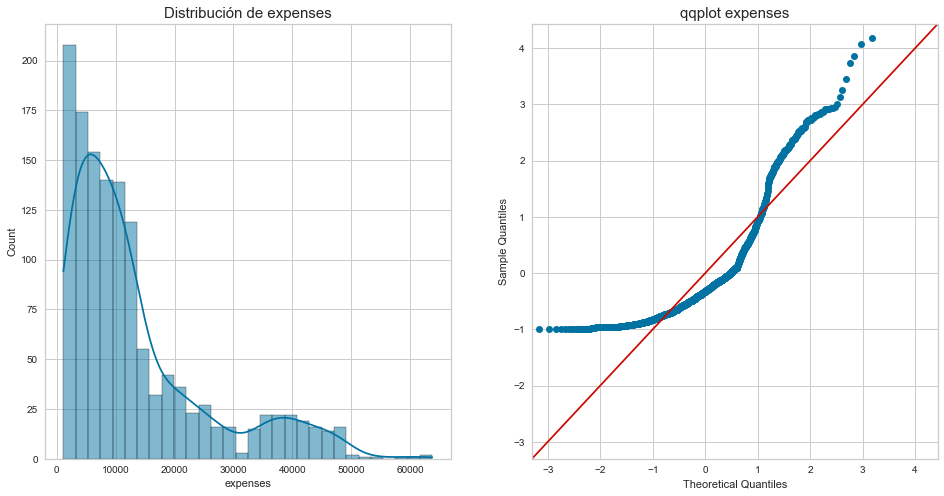

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(16,8))
sns.histplot(ax=ax[0], data=df, x='expenses', kde=True)
sm.qqplot(ax=ax[1], data=df['expenses'], fit=True, line='45')

ax[0].set_title('Distribución de expenses', fontdict={'fontsize': '15'})
ax[1].set_title('qqplot expenses', fontdict={'fontsize': '15'});

In [29]:
df['expenses_log'] = np.log(df['expenses'])

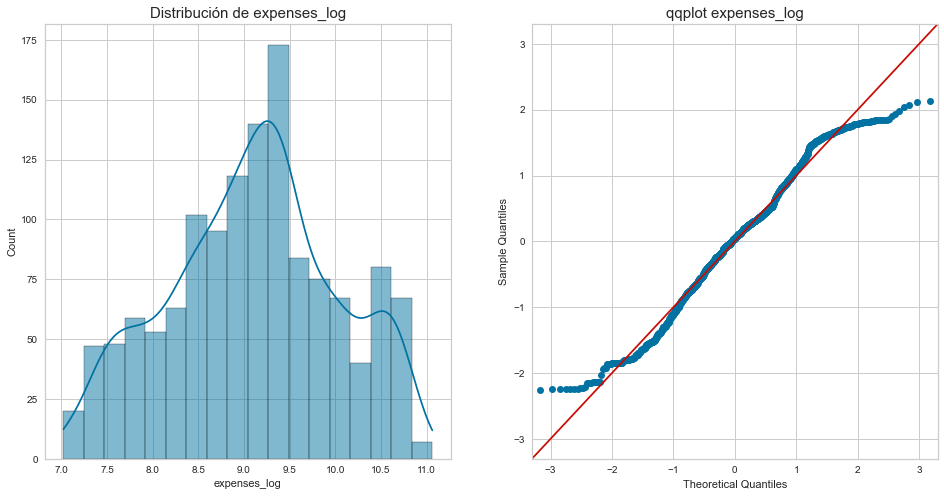

In [30]:
fig, ax = plt.subplots(1, 2, figsize=(16,8))
sns.histplot(ax=ax[0], data=df, x='expenses_log', kde=True)
sm.qqplot(ax=ax[1], data=df['expenses_log'], fit=True, line='45')

ax[0].set_title('Distribución de expenses_log', fontdict={'fontsize': '15'})
ax[1].set_title('qqplot expenses_log', fontdict={'fontsize': '15'});

<h1 style='background-color: #2C8695; color:#FFFFFF; text-align:center'>Modelado</h1>

In [31]:
df.head()

,age,bmi,children,expenses,sex_male,region_northwest,region_southeast,region_southwest,smoker_yes,expenses_log
0,19,27.9,0,16884.92,0,0,0,1,1,9.734176
1,18,33.8,1,1725.55,1,0,1,0,0,7.453301
2,28,33.0,3,4449.46,1,0,1,0,0,8.400538
3,33,22.7,0,21984.47,1,1,0,0,0,9.998092
4,32,28.9,0,3866.86,1,1,0,0,0,8.260198


In [32]:
y= df['expenses_log']
X = df.drop(columns=['expenses_log', 'expenses'])

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [34]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [35]:
def reportar_metricas(y_test, y_pred, title):
    print(title, ':')
    print('r_2:', round(r2_score(y_test, y_pred), 2))
    print('MAE:', round(mean_absolute_error(y_test, y_pred), 2)) 
    print('MSE:', round(mean_squared_error(y_test, y_pred), 2)) 
    print('RMSE:', round(np.sqrt(mean_squared_error(y_test, y_pred)), 2))

In [36]:
# Guardaremo los resultados de las predicciones en esta lista
resultados_r2 = {}

<h2 style="background-color: #2C8695; color:#FFFFFF">Linear Regression (Base)</h2>
<p>Definimos un modelo base para hacer comparaciones.</p>

In [37]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
score_lr = r2_score(y_test, y_pred_lr)
resultados_r2['Linear Regression'] = score_lr

In [38]:
reportar_metricas(y_test, y_pred_lr, 'Linear Regression')

Linear Regression :
r_2: 0.78
MAE: 0.27
MSE: 0.18
RMSE: 0.42


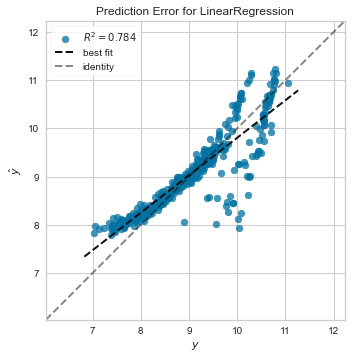

In [39]:
predict_error_lr = PredictionError(lr)
predict_error_lr.fit(X_train, y_train)
predict_error_lr.score(X_test, y_test)
predict_error_lr.show();


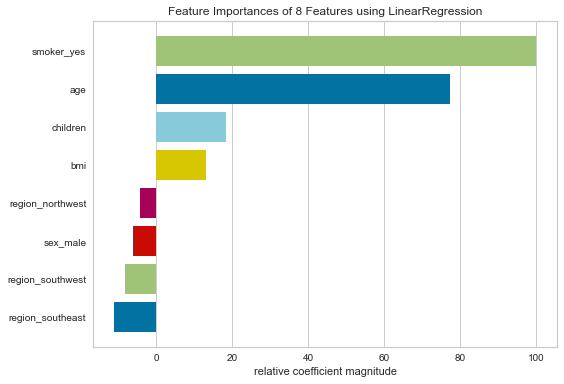

In [40]:
feature_importance_lr = FeatureImportances(lr, labels=X.columns)
feature_importance_lr.fit(X_train, y_train)
feature_importance_lr.show();

<h2 style='background-color: #2C8695; color:#FFFFFF'>Ridge Regression</h2>

In [41]:
ridge = GridSearchCV(estimator = Ridge(),
                            param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
                            scoring = 'r2',
                            cv = 10,
                            n_jobs = -1)
ridge.fit(X_train, y_train)
ridge_best = ridge.best_estimator_.fit(X_train, y_train)
y_pred_ridge_best = ridge_best.predict(X_test)
score_ridge_best = r2_score(y_test, y_pred_ridge_best)
resultados_r2['Ridge'] = score_ridge_best

In [42]:
reportar_metricas(y_test, y_pred_ridge_best, 'Ridge Regression')

Ridge Regression :
r_2: 0.78
MAE: 0.27
MSE: 0.18
RMSE: 0.43


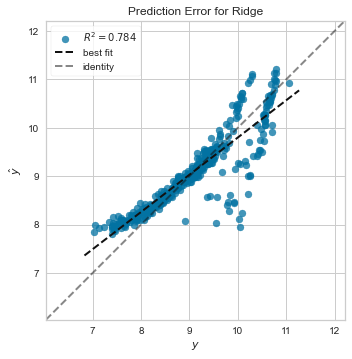

In [43]:
predict_error_ridge = PredictionError(ridge_best)
predict_error_ridge.fit(X_train, y_train)
predict_error_ridge.score(X_test, y_test)
predict_error_ridge.show();

<h2 style='background-color: #2C8695; color:#FFFFFF'>Gradient Boosting Regressor</h2>

In [44]:
gradientBoosting = GridSearchCV(estimator = GradientBoostingRegressor(),
                            param_grid = {'n_estimators': np.arange(50, 800, 50),
                                            'max_depth': np.arange(2, 11, 1),
                                            'learning_rate': [0.1, 0.05, 0.01, 0.005, 0.001]},
                            scoring = 'r2',
                            cv = 10,
                            n_jobs = -1)
gradientBoosting.fit(X_train, y_train)
gradientBoosting_best = gradientBoosting.best_estimator_.fit(X_train, y_train)
y_pred_gradientBoosting_best = gradientBoosting_best.predict(X_test)
score_gradientBoosting_best = r2_score(y_test, y_pred_gradientBoosting_best)
resultados_r2['Gradient Boosting'] = score_gradientBoosting_best

In [45]:
reportar_metricas(y_test, y_pred_gradientBoosting_best, 'Gradient Boosting Regression')

Gradient Boosting Regression :
r_2: 0.84
MAE: 0.19
MSE: 0.13
RMSE: 0.37


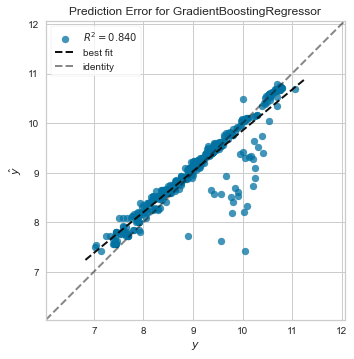

In [46]:
predict_error_gb = PredictionError(gradientBoosting_best)
predict_error_gb.fit(X_train, y_train)
predict_error_gb.score(X_test, y_test)
predict_error_gb.show();

<h2 style='background-color: #2C8695; color:#FFFFFF; text-align:left'>Random Forest Regressor</h2>

In [47]:
rfRegressor = RandomizedSearchCV(estimator = RandomForestRegressor(),
                            param_distributions = {'n_estimators': np.arange(50, 800, 50),
                                            'max_depth': np.arange(2, 11, 1),
                                            'max_features': ['auto', 'sqrt', 'log2']},
                            scoring = 'r2',
                            cv = 10,
                            n_jobs = -1)
rfRegressor.fit(X_train, y_train)
rfRegressor_best = rfRegressor.best_estimator_.fit(X_train, y_train)
y_pred_rfRegressor_best = rfRegressor_best.predict(X_test)
score_rfRegressor_best = r2_score(y_test, y_pred_rfRegressor_best)
resultados_r2['Random Forest'] = score_rfRegressor_best

In [48]:
reportar_metricas(y_test, y_pred_rfRegressor_best, 'Random Forest Regression')

Random Forest Regression :
r_2: 0.83
MAE: 0.21
MSE: 0.14
RMSE: 0.38


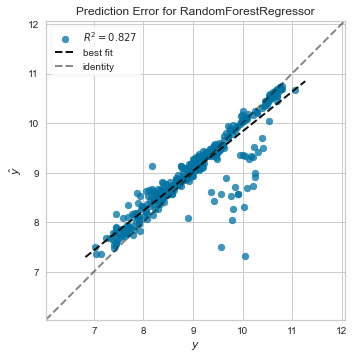

In [49]:
predict_error_rf = PredictionError(rfRegressor_best)
predict_error_rf.fit(X_train, y_train)
predict_error_rf.score(X_test, y_test)
predict_error_rf.show();

<h1 style='background-color: #2C8695; color:#FFFFFF; text-align:left'>Elección del mejor modelo</h1>

In [60]:
r2_df = pd.DataFrame(resultados_r2, index=['R2']).T.sort_values(by='R2', ascending=False)
r2_df

,R2
Gradient Boosting,0.840447
Random Forest,0.830242
Linear Regression,0.784476
Ridge,0.784255


El mejor modelo en cuanto el $R^2$, es el **Gradient Boosting**, que es el que más se ajusta a los datos. A continuación se analizará más a profundidad.

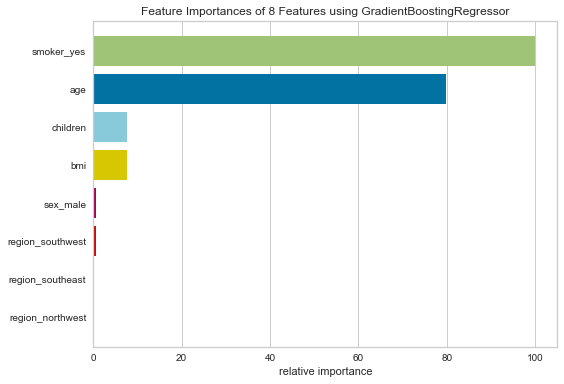

In [59]:
feature_importance_gb = FeatureImportances(gradientBoosting_best, labels=X.columns)
feature_importance_gb.fit(X_train, y_train)
feature_importance_gb.show();

* Los dos atributos que aportan mayormente a la explicabilidad de la variable objetivo son **'smoker_yes'**, que nos dice si la persona fuma y **'age'**, que nos dice su edad.
* En una segunda instancia, aunque aportan en menor medida, está **'children'** que nos dice la cantidad de hijos que tiene la persona y **'bmi'** que nos dice su índice de masa corporal.
* Las demás variables no aportan mucho a la explicabilidad de la variable objetivo.


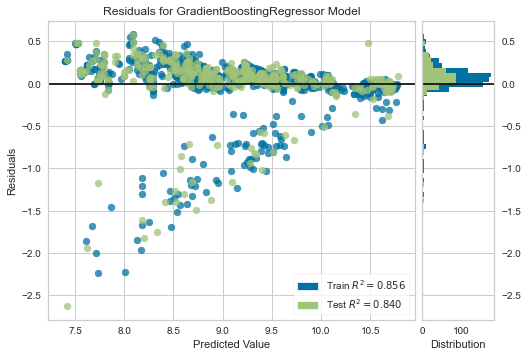

In [83]:
residual_plot_gb = ResidualsPlot(gradientBoosting_best)
residual_plot_gb.fit(X_train, y_train)
residual_plot_gb.score(X_test, y_test)
residual_plot_gb.show();

Si bien el error de la regresión es bajo, con este gráfico podemos notar que el modelo es propenso algunas veces a tener un error más grande en valores bajos, lo cual se va corrigiendo a medida que aumenta el valor predicho.

Por otra parte, se observa que el valor de $R^2$ en el train y el test es muy similar, lo que nos indica que **no estamos afectados por overfitting**.

In [85]:
model_filename = 'insurance_model_gb.sav'
pickle.dump(gradientBoosting_best, open(model_filename, 'wb'))